Why semi-supervised learning?

https://stats.stackexchange.com/questions/321841/what-are-variational-autoencoders-and-to-what-learning-tasks-are-they-used

Ideal parameters:
$$ \min_{\boldsymbol{\lambda}}\mathcal{D}[p(\mathbf{z}\vert \mathbf{x})\vert\vert q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda})] $$

It should also minimize the reconstruction loss (and optional regularization terms, mainly L1 or L2)

VAE loss function:
$$ELBO(\boldsymbol{\lambda})= E_{q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})}[\log p(\mathbf{x}\vert\boldsymbol{z})]-\mathcal{D}[(q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})]$$

$$ q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda}) = \mathcal{N}(\mathbf{z}\vert\boldsymbol{\mu}(\mathbf{x}), \boldsymbol{\sigma}^2(\mathbf{x})I) $$

conditional distribution:
$$ p_{\boldsymbol{\phi}}(\mathbf{x}\vert\mathbf{z}) = \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}(\mathbf{z}; \boldsymbol{\phi}), \boldsymbol{\sigma}(\mathbf{z}; \boldsymbol{\phi})^2I)$$


$$ ELBO(\boldsymbol{\theta},\boldsymbol{\phi})= \sum_i E_{q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})}[\log p_{\boldsymbol{\phi}}(\mathbf{x}_i\vert\boldsymbol{z})]-\mathcal{D}[(q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})] $$

In [1]:
# Import packages
from data_preparation.GeoParser import GeoParser
from dimension_reduction.ordination import ordination2d
from sklearn.decomposition import PCA
from IPython.display import Image

Import models

In [2]:
from models.semi_supervised.deep_generative_models.models.auxiliary_dgm import AuxiliaryDeepGenerativeModel
from models.semi_supervised.deep_generative_models.models.ladder_dgm import LadderDeepGenerativeModel
from models.semi_supervised.deep_generative_models.models.dgm import DeepGenerativeModel
from utils.utils import dict_of_int_highest_elements, plot_evaluation

/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


O-sylvester


In [3]:
# files_destinations
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"

plots_folder_path = "/".join([home_path, destination_folder, results_folder, "plots/"])


In [4]:
#dataset_name = "gse33000_and_GSE24335_GSE44768_GSE44771_GSE44770"
dataset_name = "gse33000+4"
geo_ids = ["GSE33000"]
unlabelled_geo_ids = ["GSE33000", "GSE24335", "GSE44768", "GSE44771", "GSE44770"]
activation = "relu"
#nrep = 3
betas=(0.9, 0.999)
vae_flavour = "o-sylvester"
early_stopping = 200
labels_per_class = 400
n_epochs = 100
warmup = 100  # was working just for VAEs (M1), not M2 (semi-supervised)


# if ladder is yes builds a ladder vae. Do not combine with auxiliary (yet; might be possible and relatively 
# not too hard to implement, but might be overkill. Might be interesting too)
translate = "n" 


In [5]:
# Types of deep generative model

# Convolution neural network (convolutional VAE and convolutional classifier)
use_conv = False #Not applicable if not sequence (images, videos, sentences, DNA...)

# Ladder VAE (L-VAE)
ladder = False

# Auxiliary Variational Auto-Encoder (A-VAE)
auxiliary = True


In [6]:
# Load pre-computed vae (unsupervised learning)
load_vae = False



Definition of the hyper-parameters

In [7]:
lr = 1e-3
initial_lr = 1e-3 #to remove, don't think it does anything anymore, but returns error without it
l1 = 1e-2
l2 = 1e-6
batch_size = 16
mc = 1 # seems to be a problem when mc > 1 for display only, results seem good
iw = 1 # seems to be a problem when iw > 1 for display only, results seem good

# Neurons layers
z_dim_last = 200 # to delete
a_dim = 200
h_dims_classifier = [512]
h_dims = [512, 512]
z_dims = [200]

# number of flows
n_combinations = 20 #could be just 1 with number_of_flows?
number_of_flows = 4
num_elements = 3



In [8]:
bad_geo_ids = [""] # Now useless, didn't work well, but stil complains without it. to be removed.

In [9]:
# Files destinations
load_from_disk = True
load_merge = False
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"
plots_folder_path = "/".join([home_path, destination_folder, results_folder, "plots/"])

In [10]:
from utils.utils import adapt_datasets
g = GeoParser(home_path=home_path, geo_ids=geo_ids, unlabelled_geo_ids=unlabelled_geo_ids, bad_geo_ids=bad_geo_ids)
g.get_geo(load_from_disk=load_from_disk, automatic_attribute_list=None)
meta_df = g.merge_datasets(load_from_disk=load_merge, labelled=True)
unlabelled_meta_df = g.merge_datasets(load_from_disk=load_merge, labelled=False)
if translate is "y":
    for geo_id in geo_ids:
        g.translate_indices_df(geo_id, labelled=True)
    for geo_id in unlabelled_geo_ids:
        g.translate_indices_df(geo_id, labelled=False)

meta_df, unlabelled_meta_df = adapt_datasets(meta_df, unlabelled_meta_df)



Running: GSE33000
Loading GSE33000, labelled: True ...
File found at location: /home/simon//annleukemia/data//GSE33000_labelledTrue_dataframe.pickle.npy
self.df[geo_id] (35371, 624)

Running unlabelled: GSE33000
Loading GSE33000, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE33000_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 624)

Running unlabelled: GSE24335
Loading GSE24335, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE24335_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 2200)

Running unlabelled: GSE44768
Loading GSE44768, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE44768_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 230)

Running unlabelled: GSE44771
Loading GSE44771, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE44771_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (

In [11]:
# PCA
#ordination2d(meta_df, epoch="pre", dataset_name=dataset_name, ord_type="pca",
#                     images_folder_path=plots_folder_path, info=str(geo_ids)+str(unlabelled_geo_ids))



In [12]:
#file_name = str(geo_ids)+str(unlabelled_geo_ids)
#image_name = "/".join([plots_folder_path,"pca", dataset_name, file_name, file_name+"_pre.png"])
#Image(image_name)

In [13]:
# t-SNE    
#ordination2d(meta_df, epoch="pre", dataset_name=dataset_name, ord_type="tsne",
#                     images_folder_path=plots_folder_path, info=str(geo_ids)+str(unlabelled_geo_ids))


In [14]:
#image_name = "/".join([plots_folder_path,"tsne", dataset_name, file_name, file_name+"_pre.png"])
#Image(image_name)

In [15]:

if auxiliary:
    dgm = AuxiliaryDeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows,a_dim=a_dim, 
                                       num_elements=num_elements, use_conv=use_conv)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=initial_lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers")

elif ladder:
    dgm = LadderDeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows, auxiliary=False)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=initial_lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers")
else:
    dgm = DeepGenerativeModel(vae_flavour, z_dims, h_dims, n_flows=number_of_flows, a_dim=None, auxiliary=False,
                              num_elements=num_elements)

    dgm.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
                    destination_folder=destination_folder, dataset_name=dataset_name, lr=initial_lr,
                    meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers")


a_dim (making sure it stays ok for ssl_vae) 0
self.a_dim 200


/home/simon/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [16]:
print("Labeled data shape (35371, 624)", meta_df.shape)
print("unlabelled meta_df shape", unlabelled_meta_df.shape)


Labeled data shape (35371, 624) (35371, 624)
unlabelled meta_df shape (35371, 3514)


In [17]:
if meta_df is not None:
    dgm.import_dataframe(meta_df, batch_size, labelled=True)
    dgm.import_dataframe(unlabelled_meta_df, batch_size, labelled=False)

In [18]:
dgm.define_configurations(early_stopping=early_stopping, warmup=warmup, flavour=vae_flavour)
dgm.set_data(labels_per_class=labels_per_class, is_example=False, has_unlabelled_samples=True)

3514 unlabelled train samples
499 train samples
62 valid samples
63 test samples
624 total samples
self.train_loader 32
self.train_loader 16
self.train_loader <torch.utils.data.sampler.RandomSampler object at 0x7f9229265898>


aux
self.input_size 35371
self.input_size 35371
Log file created:  logs/AuxiliaryDeepGenerativeModel_parameters.log
Log file created:  logs/AuxiliaryDeepGenerativeModel_involvment.log
Log file created:  logs/AuxiliaryDeepGenerativeModel.log
Labeled shape 32
Unlabeled shape 220
epoch 0


/home/simon/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[Train]		 J_a: 10497.23, L: 607.37, U: 584.58, accuracy: 0.5384, kld: 49.1
[Validation]	 J_a: 1082.65, L: 540.69, U: 542.57, accuracy: 0.6540 , kld: 54.4
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester
epoch 1
[Train]		 J_a: 7035.05, L: 479.79, U: 531.11, accuracy: 0.6741, kld: 30.6
[Validation]	 J_a: 1971.66, L: 934.35, U: 1037.94, accuracy: 0.7299 , kld: 61.4
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


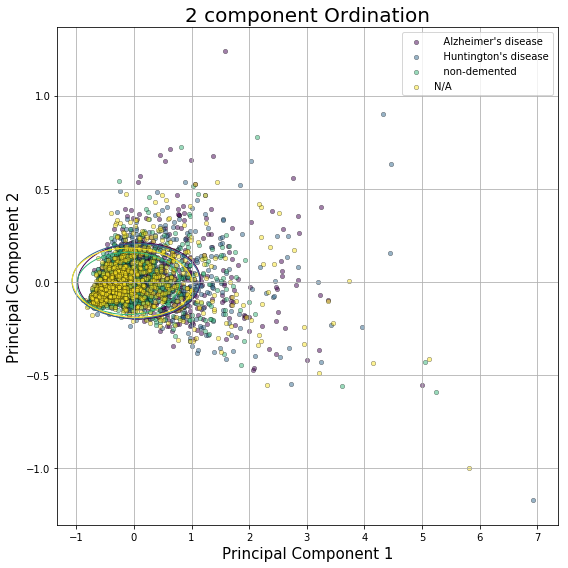

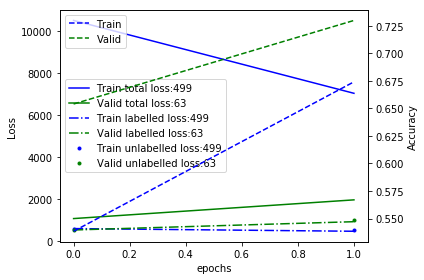

epoch 2
[Train]		 J_a: 5319.42, L: 406.16, U: 484.69, accuracy: 0.7017, kld: 19.0
[Validation]	 J_a: 708.53, L: 353.49, U: 355.62, accuracy: 0.7344 , kld: 31.3
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


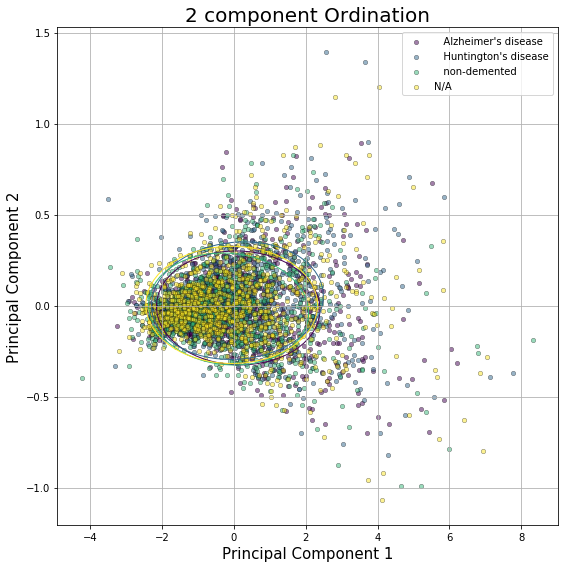

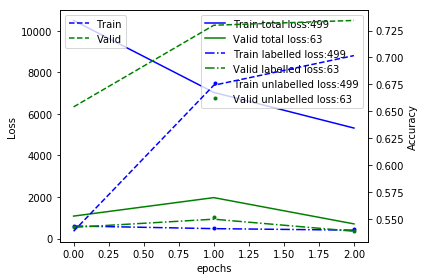

epoch 3
[Train]		 J_a: 3984.60, L: 347.87, U: 442.05, accuracy: 0.6955, kld: 22.3
[Validation]	 J_a: 666.31, L: 337.34, U: 329.47, accuracy: 0.6808 , kld: 21.2
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


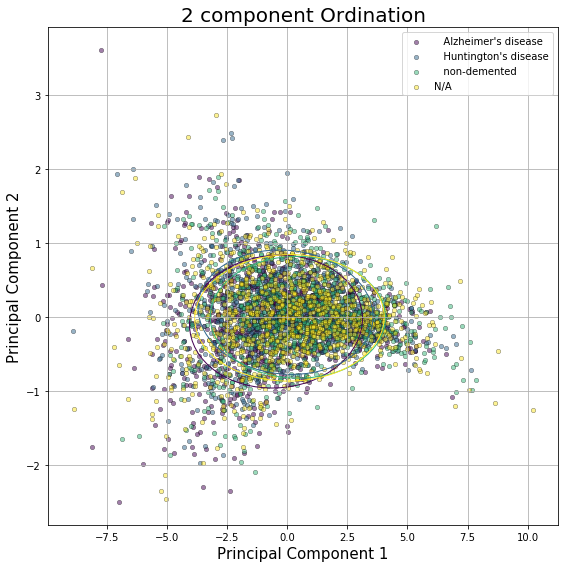

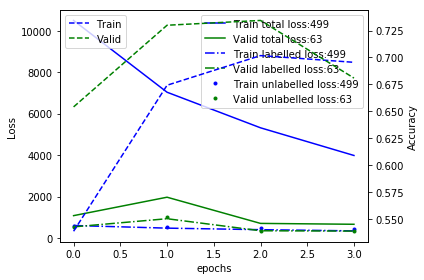

epoch 4
[Train]		 J_a: 3057.54, L: 317.98, U: 412.57, accuracy: 0.6747, kld: 18.3
[Validation]	 J_a: 600.00, L: 303.06, U: 297.45, accuracy: 0.7723 , kld: 15.2
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


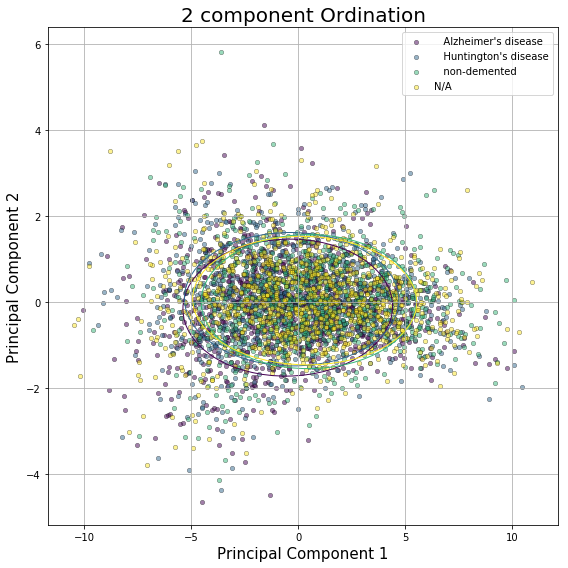

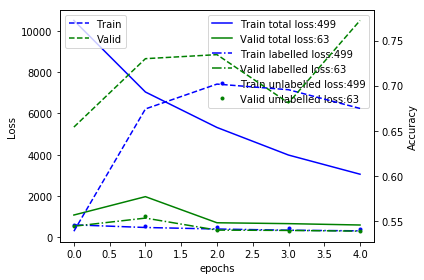

epoch 5
[Train]		 J_a: 2414.13, L: 301.69, U: 400.50, accuracy: 0.6533, kld: 13.0
[Validation]	 J_a: 573.79, L: 285.56, U: 288.77, accuracy: 0.7768 , kld: 17.0
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


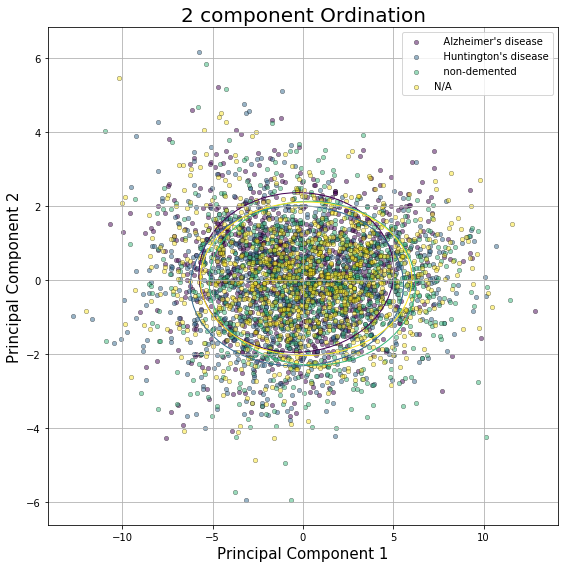

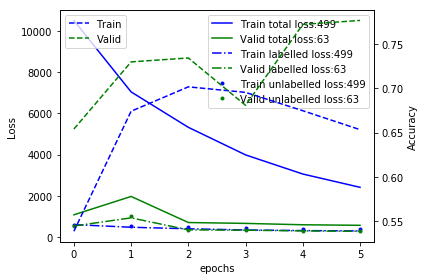

epoch 6
[Train]		 J_a: 2045.94, L: 290.03, U: 391.53, accuracy: 0.6804, kld: 14.1
[Validation]	 J_a: 581.48, L: 299.06, U: 283.16, accuracy: 0.6585 , kld: 15.2
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


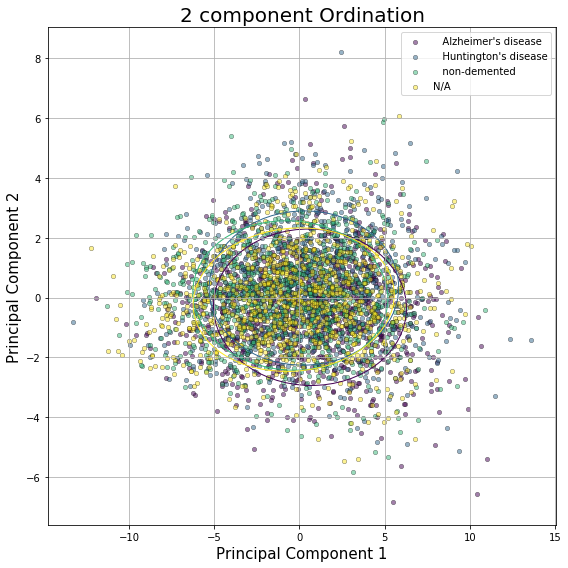

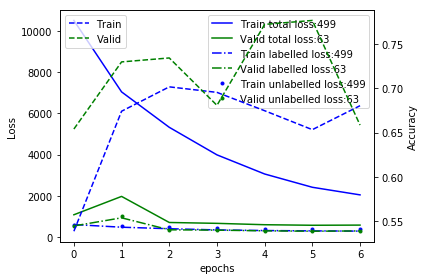

epoch 7
[Train]		 J_a: 1833.23, L: 280.31, U: 384.25, accuracy: 0.6729, kld: 12.4
[Validation]	 J_a: 546.22, L: 270.41, U: 276.26, accuracy: 0.7321 , kld: 15.7
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


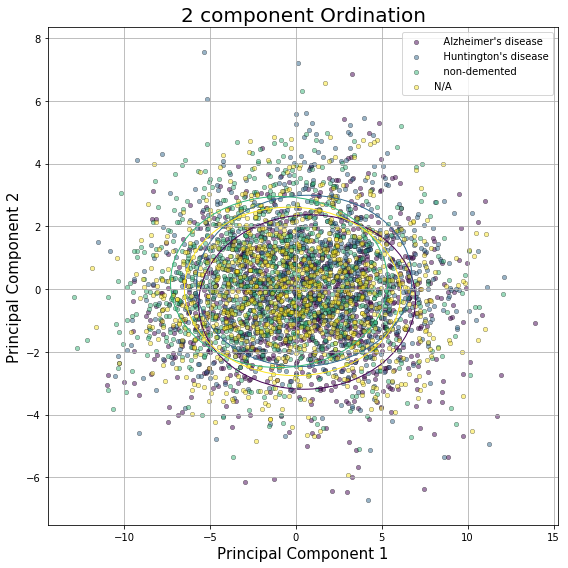

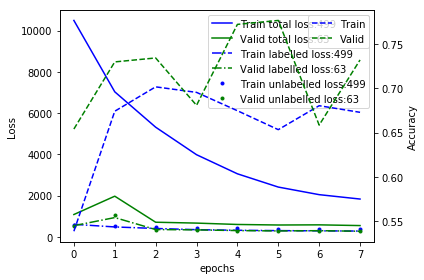

epoch 8
[Train]		 J_a: 1688.63, L: 274.85, U: 376.37, accuracy: 0.6712, kld: 10.2
[Validation]	 J_a: 570.65, L: 284.09, U: 287.24, accuracy: 0.6674 , kld: 12.6
GENERATING IMAGES AT /home/simon//annleukemia/results/num_elements3/n_flows4/z_dim200/a_dim200/lr0.001/ladderFalse/o-sylvester


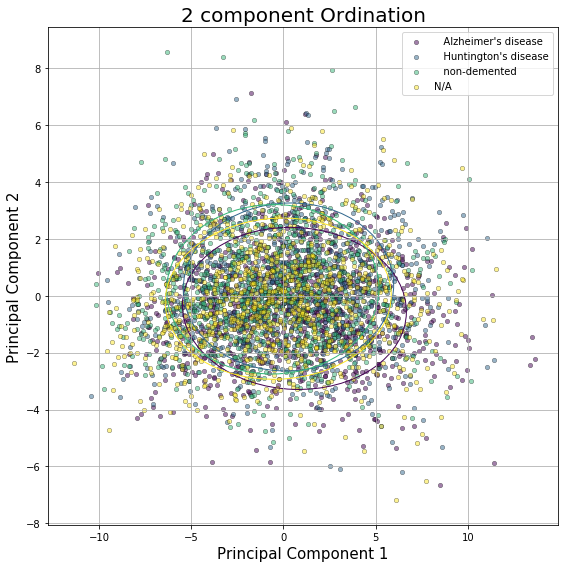

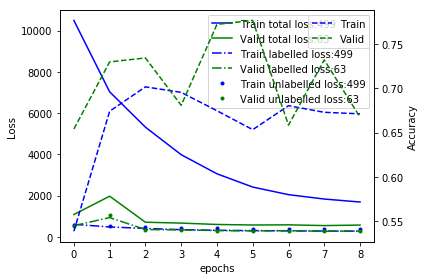

epoch 9


KeyboardInterrupt: 

In [19]:
if auxiliary:
    if use_conv:
        dgm.set_conv_adgm_layers()
    else:
        print("aux")
        dgm.set_adgm_layers(h_dims=h_dims_classifier)
elif ladder:
    dgm.set_ldgm_layers()
else:
    if use_conv:
        dgm.set_conv_dgm_layers()
    else:
        print("MAIN DGM NS")
        dgm.set_dgm_layers()

# import the M1 in the M1+M2 model (Kingma et al, 2014). Not sure if it still works... 
if load_vae:
    print("Importing the model: ", dgm.model_file_name)
    if use_conv:
        dgm.import_cvae()
    else:
        dgm.load_model()
    #dgm.set_dgm_layers_pretrained()
dgm.cuda()
# dgm.vae.generate_random(False, batch_size, z1_size, [1, 28, 28])
dgm.run(n_epochs, auxiliary, mc, iw, lambda1=l1, lambda2=l2, verbose=1, show_progress=True, show_pca_train=True, show_pca_generated=True )


References
Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114
Semi-Supervised Learning with Deep Generative Models https://arxiv.org/abs/1406.5298
Ladder Variational Autoencoders https://arxiv.org/abs/1602.02282
Auxiliary Deep Generative Models    https://arxiv.org/abs/1602.05473
Sylvester Normalizing Flows for Variational Inference  https://arxiv.org/abs/1803.05649
Improving Variational Auto-Encoders using Householder Flow https://arxiv.org/abs/1611.09630
Variational Inference with Normalizing Flows https://arxiv.org/abs/1505.05770
Convex combination linear IAF and the Householder Flow, J.M. Tomczak & M. Welling https://jmtomczak.github.io/deebmed.html

Github Ressources:
    https://github.com/wohlert/semi-supervised-pytorch
    https://github.com/jmtomczak/vae_vpflows
    https://github.com/jmtomczak/vae_householder_flow